In [ ]:
!pip install -q igraph leidenalg  # For clustering

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [1]:

import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
from GraphST.GraphST import GraphST
from GraphST.utils import clustering
import networkx as nx
import torch
import numpy as np
import pandas as pd

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
adata = sq.read.visium("dataset/GraphStData/3.Human_Breast_Cancer")
adata

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
adata_sc = sc.read_h5ad("dataset/GraphStData/3.Human_Breast_Cancer/scRNA.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 45647 × 5000
    obs: 'cell_type', 'cell_type_level_2'

In [4]:
adata_sc.obs

,cell_type,cell_type_level_2
GGGACCTAGCATGGCA-1--GSM4476487,macrophage/DC/monocyte,macrophage/DC/monocyte
CCCTGATCACGAGGAT-1--GSM5022605,macrophage/DC/monocyte,macrophage/DC/monocyte
TTCCACGGTTGGACTT-1--GSM4909270,fibroblast,fibroblast
TGGTTAGGTTGATTGC-1--GSM5022603,macrophage/DC/monocyte,macrophage/DC/monocyte
CID44971_GCTGCTTTCGCCGTGA--GSM5354531,macrophage/DC/monocyte,macrophage/DC/monocyte
...,...,...
GGCTGTGGTTTGGAAA-1--GSM4909287,macrophage/DC/monocyte,macrophage/DC/monocyte
TGCCCTACACGACTCG.Pre_P025_t--GSM5188386,T cell,T cell
CGTTGGGAGCGCCTCA-1--GSM4909281,macrophage/DC/monocyte,macrophage/DC/monocyte
CTGATAGCATCCGTGG.Pre_P022_t--GSM5188388,T cell,T cell


In [ ]:
# graphclust = pd.read_csv("dataset/V1_Human_Lymph_Node/analysis/clustering/graphclust/clusters.csv")
# graphclust.set_index("Barcode", inplace=True)
# adata.obs['graphclust'] = graphclust['Cluster'] - 1

In [7]:
# device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
gst = GraphST(adata, adata_sc=adata_sc, device=device, deconvolution=True)

/home/amintehrani/graphst-test/venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
gadata = gst.train()
gadata

Begin to train ST data...


  0%|          | 0/600 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3798x3001 and 5000x64)

In [ ]:
clustering(gadata, method="leiden")

In [ ]:
G = nx.from_numpy_array(gadata.obsm['adj'])

In [15]:
hires_scale = adata.uns['spatial']['V1_Human_Lymph_Node']['scalefactors']['tissue_hires_scalef']
coords_hires = adata.obsm['spatial'] * hires_scale
pos = coords_hires

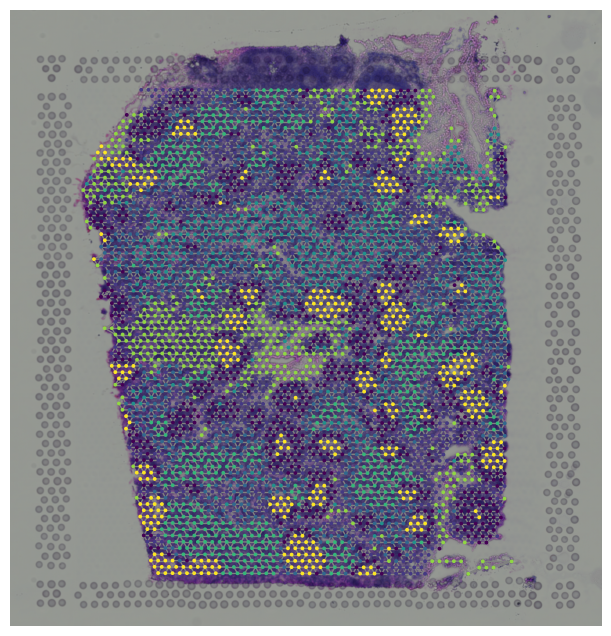

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['graphclust'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
plt.show()

NameError: name 'G' is not defined

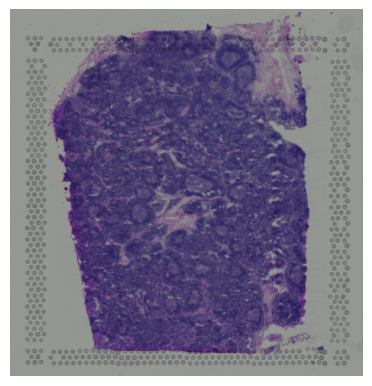

In [10]:
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 2, 1)
ax.imshow(adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['graphclust'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
ax.set_title("True Clustering")

ax = plt.subplot(1, 2, 2)
ax.imshow(adata.uns['spatial']['V1_Human_Lymph_Node']['images']['hires'])
ax.invert_yaxis()
ax.axis('off')
nx.draw(G, pos=pos, node_size=3, node_color=gadata.obs['leiden'].astype(int).tolist(), edge_color='gray', with_labels=False, ax=ax)
ax.set_title("GraphST using Leiden clustering")

plt.show()

In [2]:
adata

NameError: name 'adata' is not defined

In [9]:
gst.train_sc()

Begin to train scRNA data...


  0%|          | 0/600 [00:00<?, ?it/s]


AttributeError: 'GraphST' object has no attribute 'feat_sc'